This is a (somewhat rambling) first look through the competition data. Pardon the messiness, as I doubled back and revised earlier things on my way through but haven't taken the time to reorganize everything.

In [1]:
import numpy as np
import pandas as pd
import re
import copy
import gensim

In [2]:
from sklearn import decomposition, preprocessing
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import NMF
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss,roc_auc_score
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline

In [4]:
np.set_printoptions(precision=6,suppress=True)

In [6]:
full_train = pd.read_csv('../train.csv')
full_train.shape

(95851, 8)

In [10]:
full_train.sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
72261,753840787957,"""\n\n Papa Roach \n\nPlease bother to read the...",0,0,0,0,0,0
73648,768179415144,"That´s what Genesis flood narrative is for, th...",0,0,0,0,0,0
73103,762462740243,John and Peter Middleton \n\nI've got what I'v...,0,0,0,0,0,0
56621,590416132995,Unspecified source for Image:SuperShieldPack.J...,0,0,0,0,0,0
57316,597488392912,"Yes, I agree, and so do all of the other edito...",1,0,0,0,0,0
8597,88751708736,"Now who is threatening? Actually, if you exten...",0,0,0,0,0,0
42106,440206432002,"""\n\n Citation quality \n\nFirst thing, I kiss...",0,0,0,0,0,0
45811,478374386450,I have proposed some of the latest pic's for I...,0,0,0,0,0,0
37709,392943307086,Lolapaloozas Preachy Fuck Award \n\nGiven for ...,1,0,1,0,0,0
45118,471253836564,I might pay more attention to details of your ...,0,0,0,0,0,0


In [8]:
full_train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [9]:
full_train.shape

(95851, 8)

### EDA on labels

Since this is a multilabel task, spend some time checking the prevalence of each tag and their relationship

In [65]:
labels = full_train[['toxic', 'severe_toxic', 'obscene', 'threat','insult', 'identity_hate']]

In [15]:
# rate of any kind of toxic comment
np.mean(np.max(labels,axis=1))

0.10213769287748693

In [78]:
# toxic comment rate by class
np.mean(labels,axis=0)

toxic            0.096368
severe_toxic     0.010068
obscene          0.053301
threat           0.003182
insult           0.049713
identity_hate    0.008492
dtype: float64

In [79]:
# toxic comment count by class
np.sum(labels,axis=0)

toxic            9237
severe_toxic      965
obscene          5109
threat            305
insult           4765
identity_hate     814
dtype: int64

In [10]:
# cross correlation between toxic comment types
labels.corr()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000,0.308810,0.677491,0.162967,0.648330,0.259124
severe_toxic,0.308810,1.000000,0.404540,0.133469,0.377450,0.193385
obscene,0.677491,0.404540,1.000000,0.149874,0.744685,0.287794
threat,0.162967,0.133469,0.149874,1.000000,0.157534,0.123971
insult,0.648330,0.377450,0.744685,0.157534,1.000000,0.331922
identity_hate,0.259124,0.193385,0.287794,0.123971,0.331922,1.000000


In [14]:
clean_comment = np.zeros(shape=[labels.shape[0]])

NameError: name 'labels' is not defined

In [67]:
clean_comment[np.max(labels,axis=1)==0] = 1

In [68]:
np.mean(clean_comment)

0.89786230712251303

In [44]:
full_train[full_train['severe_toxic']==1].sample(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
13674,141333131806,FUCK YOU ALL! \n\nGO TO HELL!,1,1,1,0,1,0
82164,856986227845,"spam \n\nim spamming you, cause you're a cunt ...",1,1,1,0,1,0
4974,51982356971,WIKIPEDIA SUCKS!! IT SHOULD BURN!!,1,1,1,0,0,0
82599,861489153164,I Fucked Your Mom Last Night. It Felt Awsome. ...,1,1,1,0,1,0
39699,414844105394,"Hey, you freaking retard \n\nDon't call people...",1,1,0,0,1,0
67709,705386613723,you're such a douche fag,1,1,1,0,1,0
67345,701305227406,Go fuck yourself this ain't any of your busine...,1,1,1,0,1,0
51772,539871533752,Go fuck yourself bitch,1,1,1,0,1,0
3230,32895402228,Fuck You \n\nfuck you and wikipedia there is n...,1,1,1,0,1,0
16270,168350432858,you are a fucking bawbag.\n\nget a real job yo...,1,1,1,1,1,0


In [46]:
np.mean(labels[labels['severe_toxic']==1]['toxic'])

1.0

In [47]:
np.mean(labels[labels['severe_toxic']==1]['obscene'])

0.9544041450777202

In [48]:
np.mean(labels[labels['severe_toxic']==1]['insult'])

0.8632124352331606

In [83]:
np.mean(labels[labels['threat']==1]['toxic'])

0.9475409836065574

In [84]:
np.mean(labels[labels['identity_hate']==1]['toxic'])

0.9226044226044227

In [73]:
labels_normal = preprocessing.scale(labels)
pca = PCA(n_components=6)
pca.fit(labels_normal)
print(labels.columns)
print(pca.components_)

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')
[[ 0.48405924  0.34247257  0.51908776  0.17281606  0.51548957  0.28870781]
 [-0.13923021  0.02642394 -0.1677628   0.94685966 -0.14072525  0.18821676]
 [-0.14875063 -0.18168182 -0.13369145 -0.23323624 -0.04924426  0.93282765]
 [-0.31112749  0.91315178 -0.13916213 -0.13376885 -0.16652343  0.06605487]
 [-0.78065613 -0.11346711  0.30275552  0.03398832  0.52955722 -0.06674032]
 [-0.13397965 -0.04780236  0.75729989  0.01195527 -0.63551633  0.04730028]]


[ 0.47469283  0.63376563  0.77230727  0.89876336  0.95833061  1.        ]


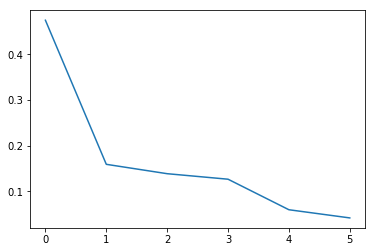

In [75]:
print(np.cumsum(pca.explained_variance_)/sum(pca.explained_variance_))
plt.plot(pca.explained_variance_/sum(pca.explained_variance_))

It is evident from the PCA that there is a lot of correlation between the types of toxic comments. Threats and identity hate are more unlike the other types.

### Word analysis on comment text

In [11]:
comments=full_train['comment_text'].tolist()

In [12]:
comments[0:3]

["Nonsense?  kiss off, geek. what I said is true.  I'll have your account terminated.",
 '"\n\n Please do not vandalize pages, as you did with this edit to W. S. Merwin. If you continue to do so, you will be blocked from editing.    "',
 '"\n\n ""Points of interest"" \n\nI removed the ""points of interest"" section you added because it seemed kind of spammy. I know you probably didn\'t mean to disobey the rules, but generally, a point of interest tends to be rather touristy, and quite irrelevant to an area culture. That\'s just my opinion, though.\n\nIf you want to reply, just put your reply here and add {{talkback|Jamiegraham08}} on my talkpage.   "']

In [15]:
token_dict = {}
token_set = set()
tokenized_comments = copy.copy(comments)
token_comment_dicts = []
for i in range(len(tokenized_comments)):
#     clean_flag = clean_comment[i]
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')
    line_dict = {}
    line_set = set()
    for token in tokenized_comments[i]:        
        if token in token_set:
#             token_dict[token]['freq'] += 1
#             token_dict[token]['clean_freq'] += clean_flag
            token_dict[token] += 1
        else:
            token_set.add(token)
#             token_dict[token] = {'freq':1,'clean_freq':clean_flag}
            token_dict[token] = 1
        if token in line_set:
            line_dict[token]+=1
        else:
            line_set.add(token)
            line_dict[token]=1
    token_comment_dicts.append(line_dict)

In [405]:
print(token_comment_dicts[1])

{'please': 1, 'do': 2, 'not': 1, 'vandalize': 1, 'pages': 1, 'as': 1, 'you': 3, 'did': 1, 'with': 1, 'this': 1, 'edit': 1, 'to': 2, 'w': 1, 's': 1, 'merwin': 1, 'if': 1, 'continue': 1, 'so': 1, 'will': 1, 'be': 1, 'blocked': 1, 'from': 1, 'editing': 1}


In [395]:
print(tokenized_comments[0:3])

[['nonsense', 'kiss', 'off', 'geek', 'what', 'i', 'said', 'is', 'true', "i'll", 'have', 'your', 'account', 'terminated'], ['please', 'do', 'not', 'vandalize', 'pages', 'as', 'you', 'did', 'with', 'this', 'edit', 'to', 'w', 's', 'merwin', 'if', 'you', 'continue', 'to', 'do', 'so', 'you', 'will', 'be', 'blocked', 'from', 'editing'], ['points', 'of', 'interest', 'i', 'removed', 'the', 'points', 'of', 'interest', 'section', 'you', 'added', 'because', 'it', 'seemed', 'kind', 'of', 'spammy', 'i', 'know', 'you', 'probably', "didn't", 'mean', 'to', 'disobey', 'the', 'rules', 'but', 'generally', 'a', 'point', 'of', 'interest', 'tends', 'to', 'be', 'rather', 'touristy', 'and', 'quite', 'irrelevant', 'to', 'an', 'area', 'culture', "that's", 'just', 'my', 'opinion', 'though', 'if', 'you', 'want', 'to', 'reply', 'just', 'put', 'your', 'reply', 'here', 'and', 'add', 'talkback', 'jamiegraham', 'on', 'my', 'talkpage']]


In [363]:
flat_tokens = [item for sublist in comments for item in sublist]

In [364]:
print("total words:",len(flat_tokens))
print("unique words:",len(token_dict.keys()))

total words: 37893913
unique words: 141839


In [135]:
clean_rate = np.mean(clean_comment)
toxic_rate = 1-clean_rate
print("overall toxic rate =",toxic_rate)

overall toxic rate = 0.102137692877


In [136]:
token_count = pd.DataFrame.from_dict(token_dict,orient='index').reset_index()
token_count.columns = ['token','freq','clean_freq']
token_count['toxic_freq'] = token_count['freq']-token_count['clean_freq'] 
token_count['toxic_rate'] = token_count['toxic_freq']/token_count['freq']
# IDEA: compare observed to expected toxic freq, like Chi-square
token_count['toxic_chisq_val'] = (token_count['toxic_freq'] - \
                                  token_count['freq']*toxic_rate)**2 / \
                                  token_count['freq']*toxic_rate
# multiply chisqr value by sign of (token toxic rate - overall toxic rate)
token_count['toxic_chisq_val_sign'] = token_count['toxic_chisq_val'] * \
    np.sign(token_count['toxic_rate']-toxic_rate)

In [137]:
token_count = token_count.sort_values('freq',ascending=False)\
    .reset_index(drop=True)
token_count = token_count.reset_index()    

In [352]:
print("Most frequent words:")
token_count.head(15)

Most frequent words:


,index,token,freq,clean_freq,toxic_freq,toxic_rate,toxic_chisq_val,toxic_chisq_val_sign
0,0,the,298601,284491.0,14110.0,0.047254,91.868962,-91.868962
1,1,to,178522,167827.0,10695.0,0.059909,32.516339,-32.516339
2,2,of,135454,127670.0,7784.0,0.057466,27.608489,-27.608489
3,3,and,134731,124032.0,10699.0,0.079410,7.108224,-7.108224
4,4,a,130904,116851.0,14053.0,0.107353,0.363730,0.363730
5,5,you,125189,101073.0,24116.0,0.192637,104.722539,104.722539
6,6,i,122894,109387.0,13507.0,0.109908,0.757814,0.757814
7,7,is,106226,97459.0,8767.0,0.082532,4.170611,-4.170611
8,8,that,93514,88108.0,5406.0,0.057810,18.768183,-18.768183
9,9,in,87638,82970.0,4668.0,0.053265,21.380544,-21.380544


In [353]:
print("Most toxic words:")
token_count.sort_values('toxic_chisq_val_sign',ascending=False).head(20)

Most toxic words:


,index,token,freq,clean_freq,toxic_freq,toxic_rate,toxic_chisq_val,toxic_chisq_val_sign
118,118,fuck,6301,45.0,6256.0,0.992858,510.597284,510.597284
225,225,nigger,3385,19.0,3366.0,0.994387,275.243554,275.243554
254,254,shit,2918,106.0,2812.0,0.963674,221.216872,221.216872
322,322,ass,2399,87.0,2312.0,0.963735,181.896711,181.896711
349,349,suck,2245,32.0,2213.0,0.985746,179.028458,179.028458
357,357,fucking,2195,26.0,2169.0,0.988155,175.996843,175.996843
400,400,penis,1996,47.0,1949.0,0.976453,155.841332,155.841332
395,395,die,2021,222.0,1799.0,0.890153,128.180539,128.180539
558,558,cunt,1315,11.0,1304.0,0.991635,106.267644,106.267644
5,5,you,125189,101073.0,24116.0,0.192637,104.722539,104.722539


(0, 0.0002)

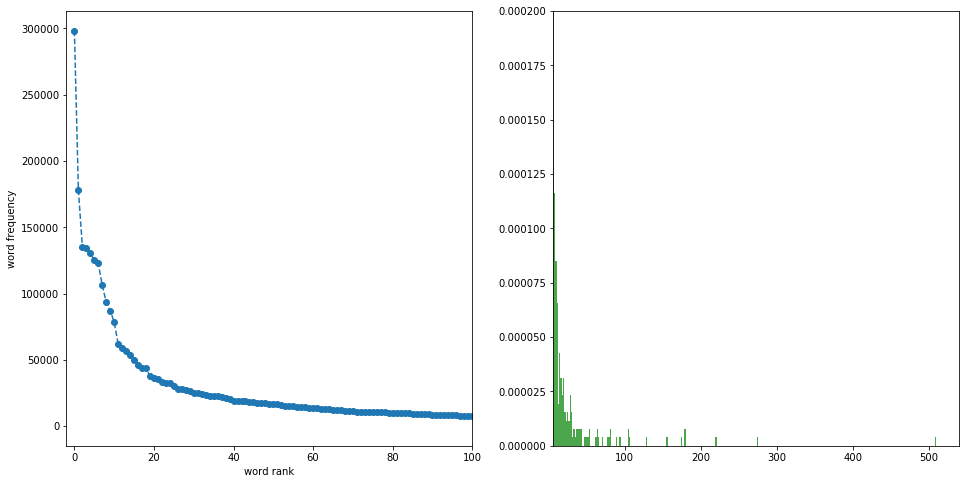

In [403]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.plot(token_count['index'],token_count['freq'],linestyle='--', marker='o')
plt.xlim([-2,100])
plt.xlabel('word rank')
plt.ylabel('word frequency')
plt.subplot(122)
n, bins, patches = plt.hist(token_count['toxic_chisq_val'], 300, normed=1, \
                            facecolor='green', alpha=0.7)
plt.xlim([6,540])
plt.ylim([0,0.0002])

In [355]:
from scipy.stats import chi2
chi2.pdf(6, 1, loc=0, scale=1)

0.0081086955549402422

In [359]:
token_count[token_count['toxic_chisq_val']>5].shape

(233, 8)

In [391]:
# token_count[token_count['toxic_chisq_val_sign']>3]\
#       .sort_values('toxic_chisq_val_sign',ascending=False)\
#       [['token','freq','toxic_chisq_val_sign']]

### Topic modeling

Try out some simple topic modeling and classification models based on them as a first attempt at things

In [151]:
# convert token dictionaries into sparse matrix
v = DictVectorizer()
v.fit(token_comment_dicts)
X = v.transform(token_comment_dicts)

In [150]:
# feature_names = v.get_feature_names()
# feature_names[0:30]

In [410]:
# TF-IDF transformation on sparse matrix
tfidf = TfidfTransformer().fit_transform(X)
tfidf.shape

(95851, 152074)

In [422]:
# non-negative matrix factorization
nmf_fit = NMF(n_components=100).fit(X=tfidf)

In [423]:
nmf_topics = nmf_fit.transform(tfidf)

In [424]:
nmf_topics.shape

(95851, 100)

In [427]:
y = 1-clean_comment
np.mean(y)

0.10213769287748693

#### Try L1 logistic regression on topics to see if they are predictive

In [430]:
lasso_lr = LogisticRegression(penalty='l1')

In [431]:
lasso_lr.fit(X=nmf_topics,y=y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [149]:
# for i in range(100):
#     print(i,lasso_lr.coef_[0][i])

In [441]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx,topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [148]:
#print_top_words(nmf_fit,feature_names,10)

In [452]:
predict=lasso_lr.predict_proba(nmf_topics)[:,1]

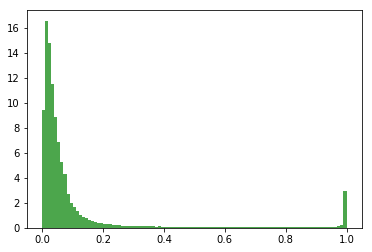

In [453]:
n, bins, patches = plt.hist(predict, 100, normed=1, facecolor='green', alpha=0.7)

In [461]:
print(log_loss(y,predict))
print(roc_auc_score(y,predict))

0.168428675779
0.930952312028


In [463]:
gbm = GradientBoostingClassifier(n_estimators=100, subsample=.5,max_depth=12)
gbm.fit(X=nmf_topics,y=y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=12,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=0.5, verbose=0, warm_start=False)

In [464]:
gbm_predict = gbm.predict_proba(nmf_topics)[:,1]

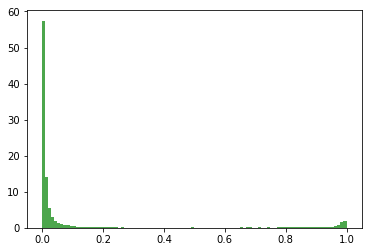

In [466]:
n, bins, patches = plt.hist(gbm_predict, 100, normed=1, facecolor='green', alpha=0.7)

In [465]:
print(log_loss(y,gbm_predict))
print(roc_auc_score(y,gbm_predict))

0.0508589239589
0.996387971907


In [469]:
multilabel_rf = RandomForestClassifier(n_estimators=100,n_jobs=-1,verbose=1)

In [486]:
multilabel_rf.fit(X=nmf_topics,y=np.array(labels))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   48.9s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=1, warm_start=False)

In [487]:
rf_predict = multilabel_rf.predict_proba(nmf_topics)

[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    2.3s finished


In [524]:
rf_predict0 = np.array(rf_predict)
rf_predict0.shape

(6, 95851, 2)

In [525]:
rf_predict0 = rf_predict0[:,:,1].T
rf_predict0.shape

(95851, 6)

In [526]:
rf_predict0[0:10]

array([[ 0.78,  0.02,  0.06,  0.  ,  0.06,  0.01],
       [ 0.01,  0.  ,  0.01,  0.  ,  0.01,  0.  ],
       [ 0.01,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.05,  0.  ,  0.01,  0.  ,  0.03,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.02,  0.  ,  0.  ,  0.  ,  0.01,  0.  ],
       [ 0.07,  0.  ,  0.02,  0.  ,  0.04,  0.  ],
       [ 0.2 ,  0.  ,  0.1 ,  0.01,  0.09,  0.01],
       [ 0.  ,  0.  ,  0.01,  0.  ,  0.01,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ]])

In [533]:
def mean_logloss(obs_y,predict_y):
    predict_y0 = copy.copy(predict_y)
    predict_y0[predict_y0==0] = 10e10
    predict_y0[predict_y0==1] = 1-10e10
    return np.mean(np.multiply(np.log(predict_y0),obs_y))

In [534]:
mean_logloss(np.array(labels),rf_predict0)

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """


nan

In [535]:
rf_predict0[rf_predict0==0] = 10e10
rf_predict0[rf_predict0==1] = 1-10e10
np.log(rf_predict0)
np.mean(np.multiply(np.log(rf_predict0),np.array(labels)))

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


nan

In [543]:
rf_predict0[rf_predict0==0] = 10e5
rf_predict0[rf_predict0==1] = 1-10e5
(np.log(rf_predict0)*np.array(labels)).shape

/Users/ChadMorgan/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


(95851, 6)

#### Try a submission with our simple topic-based model

In [12]:
testdat = pd.read_csv('test.csv')
print(testdat.shape)
testdat.head()

In [153]:
test_comments0 = testdat['comment_text'].tolist()
test_comments = copy.copy(test_comments0)
test_comment_dicts = []
for i in range(len(test_comments)):
    if type(test_comments[i]) is float:
        print(i,test_comments[i])
        test_comments[i]=[]
    else:
        test_comments[i] = re.sub("\n",' ',test_comments[i])
        test_comments[i] = re.sub("\t",' ',test_comments[i])
        test_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',test_comments[i])
        test_comments[i] = re.sub(" +",' ',test_comments[i])
        test_comments[i] = re.sub("'+","'",test_comments[i])    
        test_comments[i] = re.sub("\*+","\*",test_comments[i])   
        test_comments[i] = re.sub("\-+","\-",test_comments[i])
        test_comments[i] = test_comments[i].lower().strip()
        test_comments[i] = test_comments[i].split(' ')
        line_dict = {}
        line_set = set()
        for token in test_comments[i]:        
            if token in line_set:
                line_dict[token]+=1
            else:
                line_set.add(token)
                line_dict[token]=1
        test_comment_dicts.append(line_dict)

52300 nan


In [20]:
len(test_comments)

226998

In [ ]:
#### Topic modeling on full dataset
- Should refit topic model on all the data rather than just train
- This is unsupervised so it should be fine to include test data, which is larger

In [154]:
full_X = v.transform(token_comment_dicts + test_comment_dicts)

In [156]:
tfidf_trans = TfidfTransformer()
tfidf_trans.fit(full_X)
full_tfidf = tfidf_trans.transform(full_X)

In [ ]:
# non-negative matrix factorization
nmf_fit = NMF(n_components=100).fit(X=full_tfidf)

In [ ]:
nmf_topics = nmf_fit.transform(tfidf)

In [ ]:
test_X = v.transform(token_comment_dicts)
test_tfidf = TfidfTransformer().fit_transform(test_X)
#test_nmf_topics = nmf_fit.transform(test_tfidf)

### Word Embeddings via gensim

In [10]:
comments=full_train['comment_text'].tolist()
tokenized_comments = copy.copy(comments)
for i in range(len(tokenized_comments)):
    tokenized_comments[i] = re.sub("\n",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("\t",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("[^A-Za-z'\*\- ]",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub(" +",' ',tokenized_comments[i])
    tokenized_comments[i] = re.sub("'+","'",tokenized_comments[i])    
    tokenized_comments[i] = re.sub("\*+","\*",tokenized_comments[i])   
    tokenized_comments[i] = re.sub("\-+","\-",tokenized_comments[i])
    tokenized_comments[i] = tokenized_comments[i].lower().strip()
    tokenized_comments[i] = tokenized_comments[i].split(' ')

In [21]:
# with unsupervised learning such as word embeddings we can combine the train and test sets
combined_comments = tokenized_comments + test_comments 

In [22]:
print(len(test_comments))
print(len(tokenized_comments))
print(len(combined_comments))

226998
95851
322849


In [139]:
min_token_freq = 15
num_unique_tokens = token_count[token_count['freq']>=min_token_freq].shape[0]
print(num_unique_tokens)
print(num_unique_tokens/len(token_dict.keys()))
print(sum(token_count[token_count['freq']>=min_token_freq]['freq']/sum(token_count['freq'])))

14817
0.09743282875442219
0.950883368023


In [112]:
model = gensim.models.Word2Vec(size=50, window=7, min_count=15,iter=10,sg=1,workers=4)

In [113]:
model.build_vocab(combined_comments)

In [114]:
len(model.wv.vocab)

31293

In [115]:
model.train(combined_comments,total_examples=model.corpus_count,epochs=model.iter)

172826635

In [116]:
model.save("wiki_comment_word2vec")

In [117]:
model.wv.most_similar(positive=['spam'])

[('spamming', 0.759528398513794),
 ('inappropriate', 0.7465755343437195),
 ('linkfarm', 0.74321049451828),
 ('advertising', 0.7209452390670776),
 ('promotion', 0.7063705325126648),
 ('misinformation', 0.7014890909194946),
 ('spammer', 0.6812227964401245),
 ('self\\-promotion', 0.68116694688797),
 ('vehicle', 0.6739222407341003),
 ('links', 0.6724534630775452)]

In [118]:
model.wv.most_similar(positive=['vandalise'])

[('vandalize', 0.8179588317871094),
 ('vandalising', 0.7867379188537598),
 ('vandalizing', 0.7844653725624084),
 ('continue', 0.7751064896583557),
 ('blocked', 0.7681029438972473),
 ("will'", 0.7350543737411499),
 ('blocking', 0.7204157710075378),
 ('disruptive', 0.7179380655288696),
 ('vandilism', 0.7021838426589966),
 ('stop', 0.6999066472053528)]

In [119]:
model.wv.most_similar(positive=['wikipedia'])

[('wiki', 0.827539324760437),
 ('link', 0.7889859080314636),
 ('you', 0.6202805638313293),
 ('policy', 0.6109753847122192),
 ('please', 0.6063942909240723),
 ('page', 0.6039745211601257),
 ('to', 0.5953031778335571),
 ('articles', 0.5935777425765991),
 ('use', 0.5805928111076355),
 ('freplyspang', 0.5775981545448303)]

In [120]:
model.wv.most_similar(positive=['you'])

[('if', 0.7749486565589905),
 ('i', 0.7219581604003906),
 ('\\*you', 0.7202538251876831),
 ('freplyspang', 0.6731392741203308),
 ('to', 0.6446644067764282),
 ('this', 0.6445660591125488),
 ('please', 0.6427567601203918),
 ('wikipedia', 0.6202805042266846),
 ('want', 0.6139556765556335),
 ('do', 0.6123207807540894)]

In [144]:
model.wv.most_similar(positive=['sexist'])

[('homophobic', 0.8554118275642395),
 ('misogynistic', 0.8300203084945679),
 ('homophobe', 0.8233377933502197),
 ('racist', 0.8169455528259277),
 ('stereotyping', 0.796703577041626),
 ('slurs', 0.7959371209144592),
 ('anti\\-semetic', 0.7915410399436951),
 ('raving', 0.7762748003005981),
 ('ignorant', 0.7721282243728638),
 ('slur', 0.7623776793479919)]

In [145]:
model.wv.most_similar(positive=['geek'])

[('nerd', 0.7926405072212219),
 ('dork', 0.789850115776062),
 ('f\\*cking', 0.7774613499641418),
 ('whoop', 0.7516065239906311),
 ('nerds', 0.7490488290786743),
 ('motherfucker', 0.7446703910827637),
 ('weeaboo', 0.7423754930496216),
 ('asshole', 0.7410081624984741),
 ('awesome', 0.7408780455589294),
 ('inbred', 0.7375519871711731)]

In [130]:
model.wv.most_similar(positive=['rape'])

[('anal', 0.8929529190063477),
 ('molestation', 0.7554458975791931),
 ('murder', 0.7532585859298706),
 ('homosexual', 0.7384670972824097),
 ('mutilation', 0.733931839466095),
 ('adultery', 0.7080392241477966),
 ('crime', 0.7051728367805481),
 ('incest', 0.7027655839920044),
 ('sex', 0.6951019763946533),
 ('robbery', 0.6928032040596008)]

In [122]:
model.wv.most_similar(positive=['die'])

[('edie', 0.8378049731254578),
 ('motherfucker', 0.8153197169303894),
 ('nicht', 0.7991008758544922),
 ('einer', 0.7987916469573975),
 ('sonne', 0.7972235679626465),
 ('fag', 0.7942181825637817),
 ('wenn', 0.7893837094306946),
 ('ich', 0.7891098856925964),
 ('noch', 0.7867863774299622),
 ('sie', 0.7807758450508118)]

Some of these look like German... ("die" = "the" in DE). Will check these out...

In [77]:
full_train[full_train['comment_text'].str.contains('nicht')]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
28035,290764441780,Well-founded news in 'our' GPS/GSM-tracking ma...,0,0,0,0,0,0
74781,779295189890,""" Hasenjagd ==\nHave fun with this special kin...",0,0,0,0,0,0


In [76]:
print(full_train.loc[74781]['comment_text'])

" Hasenjagd ==
Have fun with this special kind of new (or old?) German bolshewik humour:

http://de.wikipedia.org/w/index.php?title=Wikipedia:Vandalensperrung&diff;=prev&oldid;=11367727#Unscheinbar
 
Version vom 01:23, 6. Dez 2005 Jesusfreund (Diskussion | Beiträge) PRUUUST - verschoben ins Humorarchiv, Überschrift ""der ganz normale Wahnsinn im Adminalltag"". Selten so gelacht...

cu 

 And now an anti bolshewik joke:

Ich sehe das nicht so, denn Hans Bugs Kritik hat eine wichtige Funktion. Sie stört einzelne, aber für das Wohlergehen des Projekts ist sie wichtig.  Weiße Rose 15:46, 7. Dez 2005 (CET)Ahja? Also mir hat seine ""Kritik"" bei der Erstellung einer Enzyklopaedie noch nie geholfen... DaTroll 15:47, 7. Dez 2005 (CET)
dito. GrummelJS8 15:48, 7. Dez 2005 (CET)
 Nicht überraschend. Die Funktion ist die eines Kammerjägers. Ungemütlich für das Ungeziefer. Frisch From Fröhlich Frei 16:26, 7. Dez 2005 (CET)

Source: http://de.wikipedia.org/w/index.php?title=Wikipedia_Diskussion:Benu

In [91]:
testdat0 = testdat.dropna()
testdat0[testdat0['comment_text'].str.contains('stimme')]

,id,comment_text
100235,442158514631,"Kannst Du eigentlich noch verantworten, in ein..."


In [92]:
print(testdat0.loc[100235]['comment_text'])

Kannst Du eigentlich noch verantworten, in einem derart angebräunten Projekt mitzuarbeiten? Die Artikel [WIKI_LINK: de:Oskar-Heinrich Bär@Oskar-Heinrich Bär] und [WIKI_LINK: de:Kurt Welter] werden von nazi-unterstützenden Admins regelwidrig von NPOV-Bausteinen entblösst und Diskussionsbeiträge, die die Probleme kennzeichnen regelwidrig entfernt. Bin gespannt, wie Du das siehst. Ich werde diesen u.a. von Stefan64 verbreiteten braunen Unsinn öffentlich anprangern. [WIKI_LINK: de:Benutzer:Saidpinao@Saidpinao] ([WIKI_LINK: de:Benutzer Diskussion:Saidpinao@Diskussion]) 23:43, 23. Jul. 2012 (CEST)
:Ach, ich mache mir gerade mehr Sorgen um den Artikel [WIKI_LINK: Pro-Bewegung]. Ehrlich gesagt. Was hast Du denn zu kritisieren? [EXTERNAL_LINK: Das dort] die ganzen naziblätter wiederum zitiert werden? Unter Rezeption? Ja, ist doch üblich hier! Geh auf die Diskussionsseite und versuche denen klar zu machen, dass Naziblätter hier nicht zitierfähig sind. Bei so Spezialisten wie Stefan64 ist eh Hopf

### doc2vec model